# Matched Filter

According to Wikipedia "_The matched filter is the optimal linear filter for maximizing the signal to noise ratio (SNR) in the presence of additive stochastic noise_". Lets try that on an ideal chirp and the impulse response of our transducer.

## Test chirp

Lets build our test chirp impulse.

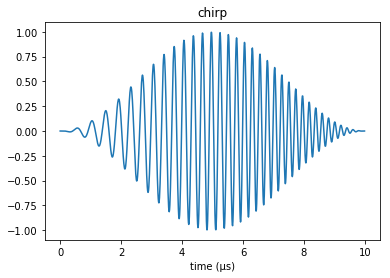

In [1]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt 

fs = 100e6     # sample rate [Hz]
f0 = 3.5e6     # transducer central frequency [Hz]
bandwidth = 1  # transducer bandwidth [%]
tau = 10e-6    # chirp duration [s]  

# test signal gonna be a chirp windowed by a hanning window
dt = 1/fs
t = np.arange(int(tau/dt))*dt
fmin = f0*(1 - bandwidth/2)
fmax = f0*(1 + bandwidth/2)

xc = sp.chirp(t, fmin, tau, fmax) * np.hanning(len(t))

plt.figure()
plt.plot(t/1e-6,xc)
plt.xlabel('time (µs)')
plt.title('chirp')
plt.show()

## FIR Coefficients

This filtering simply consist in correlating the signal with a template. In our case the template is the emittided signal. In the end we want to apply as FIR filtering because it is easy to implement on hardware. FIR filtering is nothing else than applying a convolution. To pass from correlation to convultion we just need to time reverse the template. We then normalized the coefficients. 

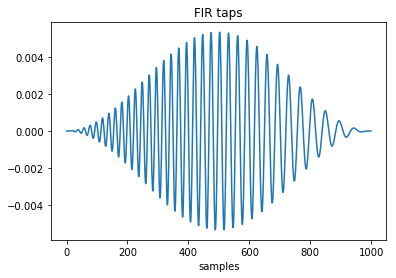

In [2]:
#Fir Coefficients are the time reverse emitted signal
firFilter = np.copy(xc)[::-1];
# We normalize it 
firFilter /= np.sum(firFilter**2);
# We plot those coefficients
plt.plot(firFilter)
plt.xlabel('samples')
plt.title('FIR taps')
plt.show()


## Applying to the emitted signal

What happened if we apply this matched filter to the emitted signal

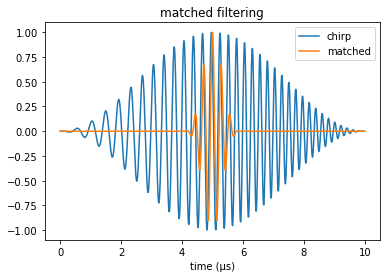

In [3]:
firChirp = np.convolve(xc,firFilter,'same')

plt.plot(t/1e-6,xc,label='chirp')
plt.plot(t/1e-6,firChirp,label='matched')
plt.xlabel('time (µs)')
plt.legend()
plt.title('matched filtering')
plt.show()

The Matched Filter compress the signal in time and incrase the temporal resolution.

## Adding Noise

What if we add noise? This filter is suited for noise rejection

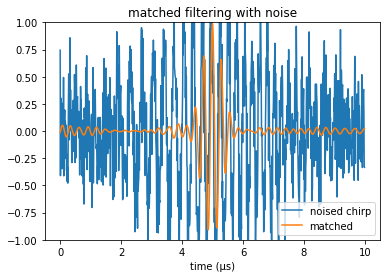

In [4]:
noise = 0.3*np.random.randn(len(xc))
firChirpNoise = np.convolve(xc + noise,firFilter,'same')

plt.plot(t/1e-6,xc + noise,label='noised chirp')
plt.plot(t/1e-6,firChirpNoise,label='matched')
plt.xlabel('time (µs)')
plt.title('matched filtering with noise')
plt.ylim([-1,1])
plt.legend()
plt.show()

This filter succed very well in rejecting noise ! Wikipedia didn't lied !

## Altering the emmitted signal

When traveling in a medium, the emitted signal can be altered. Mainly, high frequency are attenuated. Will this filter still work?

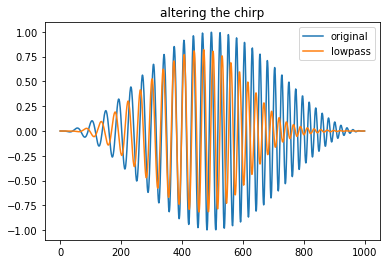

In [5]:
b,a = sp.butter(10,2*f0/fs)
xclow = sp.lfilter(b,a,xc)
plt.plot(xc,label='original')
plt.plot(xclow, label='lowpass')
plt.legend()
plt.title('altering the chirp')
plt.show()


We can now do the same experiment but this time the emited signal and the FIR coefficient won't be perfectly matched.

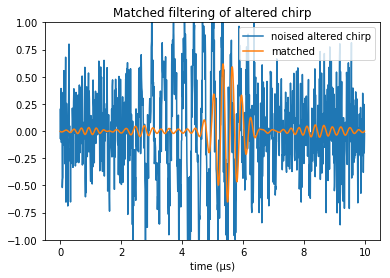

In [6]:
noise = 0.3*np.random.randn(len(xc))
firChirpAlter = np.convolve(xclow + noise,firFilter,'same')


plt.plot(t/1e-6,xclow + noise,label='noised altered chirp')
plt.plot(t/1e-6,firChirpAlter,label='matched')
plt.xlabel('time (µs)')
plt.title('Matched filtering of altered chirp')
plt.ylim([-1,1])
plt.legend()
plt.show()

We could have foresee the result. Since everything is linear, the alteration of the filtered signal is the same than the one we applied to tho original signal which sounds fair to me. The result is a bit spread and delayed.

## Test on real pulse

We are going to try this method on the actual response of the transducer. Since the pulse is alread narrow, we won't be able to compress it as above. Still, the noise rejection should work. For simplicity, we will flip this pulse upside down so that the maximal absolute value is positive.

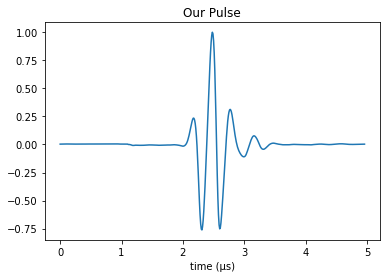

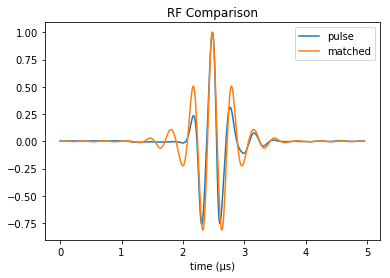

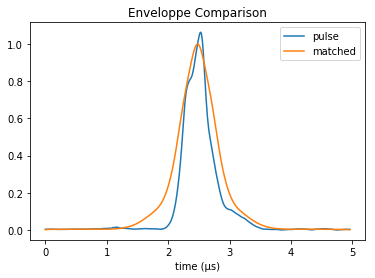

In [7]:
#Preprocessing pulse
tPulse, xPulse = np.loadtxt('pulse.csv',delimiter=',').T
xPulse -= np.mean(xPulse)
tPulse -= tPulse[0]
tPulse /= 1e6
tauPulse = tPulse[-1] - tPulse[0]
Np = tauPulse/dt
tp = np.arange(Np)*dt
xp = np.interp(tp,tPulse,xPulse)
b,a = sp.butter(6,0.25)
xp = sp.lfilter(b,a,xp)
b,a = sp.butter(6,0.001,'high')
xp = sp.lfilter(b,a,xp)
icenter = np.argmax(np.abs(xp))
d = icenter-int(Np/2)
xp = np.roll(xp,-d)
xp /= np.max(np.abs(xp))

# For simplicity and visualization
xp = -xp

plt.plot(tp/1e-6,xp,label='pulse')
plt.xlabel('time (µs)')
plt.title('Our Pulse')
plt.show()

# Apply Matched Filtering
firFilter = np.copy(xp)[::-1];
firFilter /= np.sum(firFilter**2);
firPulse = np.convolve(xp,firFilter,'same')

# Compare Impulse reponse
plt.plot(tp/1e-6,xp,label='pulse')
plt.plot(tp/1e-6,firPulse,label='matched')
plt.xlabel('time (µs)')
plt.title('RF Comparison')
plt.legend()
plt.show()

# Compare Enveloppe response
plt.plot(tp/1e-6,np.abs(sp.hilbert(xp)),label='pulse')
plt.plot(tp/1e-6,np.abs(sp.hilbert(firPulse)),label='matched')
plt.xlabel('time (µs)')
plt.title('Enveloppe Comparison')
plt.legend()
plt.show()


This filtering symmetrize the pulse. It reduce a bit the resolution (which can be assimilated as the full width at half maximum) but allows to implement ideal noise rejection which could be usefull to incrase penetration. Lets add some noise.

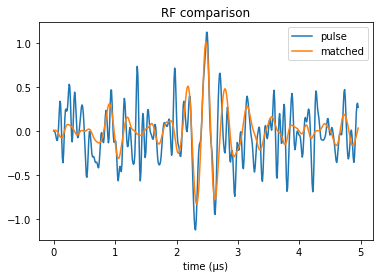

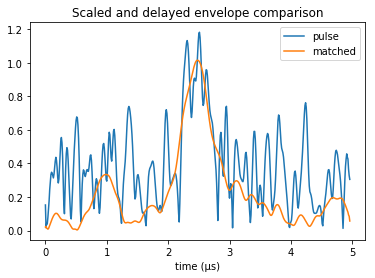

In [8]:
# Apply Matched Filtering with noise

noise = 0.5*np.random.randn(len(xp))
# Let lowpass the noise this time for a fair comparison
b,a = sp.butter(6,0.25)
noise = sp.lfilter(b,a,noise)

# Apply filter
firPulseNoise = np.convolve(xp + noise,firFilter,'same')

# Plot RF Comparison
plt.plot(tp/1e-6,xp + noise,label='pulse')
plt.plot(tp/1e-6,firPulseNoise,label='matched')
plt.xlabel('time (µs)')
plt.title('RF comparison')
plt.legend()
plt.show()

# Plot envelope comparison
plt.plot(tp/1e-6,np.abs(sp.hilbert(xp + noise)),label='pulse')
plt.plot(tp/1e-6,np.abs(sp.hilbert(firPulseNoise)),label='matched')
plt.xlabel('time (µs)')
plt.title('Scaled and delayed envelope comparison')
plt.legend()
plt.show()

Noise rejection is really good. We lose a little bit of resolution but we win a lot of SNR.

## Wiener Filter

Let see if you can do better. We optimized SNR but can we retain the initial resolution with still a good SNR ? Let do a trip in the wonderland of wiener Filter. This approach assure the best way of manipulating our pulse in presence of stochastic noise. The idea is : how much can we boost some frequency to augment resolution without amplifying to much noise. The problem of this method is that we need to do an assumption on the noise whereas it wasn't needed for matched filtering. 

## FFT Analysis

Applying a matched filter seems to incrase the full width at half maximum. It must do the contrary in frequency. Lets check that.

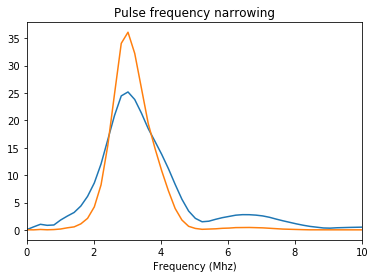

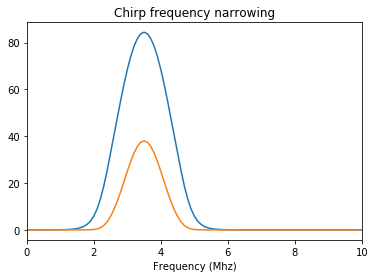

In [11]:
freqs = np.fft.fftshift(np.fft.fftfreq(len(xp),dt))/1e6
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(xp))))
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(firPulse))))
plt.xlim([0, 10])
plt.xlabel('Frequency (Mhz)')
plt.title('Pulse frequency narrowing')
plt.show()

freqs = np.fft.fftshift(np.fft.fftfreq(len(xc),dt))/1e6
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(xc))))
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(firChirp))))
plt.xlim([0, 10])
plt.xlabel('Frequency (Mhz)')
plt.title('Chirp frequency narrowing')
plt.show()

Effectively. This is the cause of the loss of resolution. Lets Try something else.

## Aimed result

We would like to have a dirac. This is fft equal to 1 for every frequency

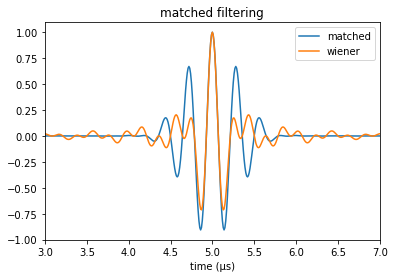

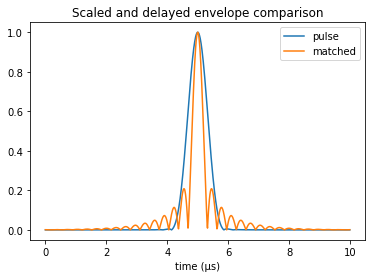

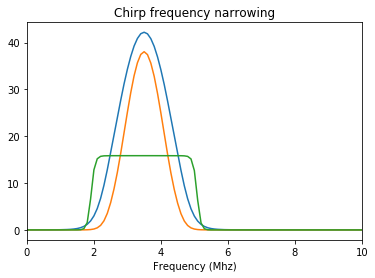

In [66]:
aim = np.zeros(xc.shape)
aim[int(len(aim)/2)] = 1

noise = 1*np.random.randn(len(xc))
# Let lowpass the noise this time for a fair comparison
b,a = sp.butter(6,0.25)
noise = sp.lfilter(b,a,noise)

H = np.fft.fft(xc)/np.fft.fft(aim)
S = abs(np.fft.fft(xc))**2
N = np.mean(abs(np.fft.fft(noise))**2)
G = np.conj(H)*S/(abs(H)**2*S + N)
result = np.real(np.fft.ifft((np.fft.fft(xc)*G)))

#plt.plot(t/1e-6,xc,label='chirp')
plt.plot(t/1e-6,firChirp,label='matched')
plt.plot(t/1e-6,result/np.max(result),label='wiener')
plt.xlabel('time (µs)')
plt.xlim([3,7])
plt.legend()
plt.title('matched filtering')
plt.show()

# Plot envelope comparison
plt.plot(t/1e-6,np.abs(sp.hilbert(firChirp)),label='pulse')
plt.plot(t/1e-6,np.abs(sp.hilbert(result/np.max(result))),label='matched')
plt.xlabel('time (µs)')
plt.title('Scaled and delayed envelope comparison')
plt.legend()
plt.show()

freqs = np.fft.fftshift(np.fft.fftfreq(len(xc),dt))/1e6
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(xc/2))))
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(firChirp))))
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(result)/np.max(result))))
plt.xlim([0, 10])
plt.xlabel('Frequency (Mhz)')
plt.title('Chirp frequency narrowing')
plt.show()


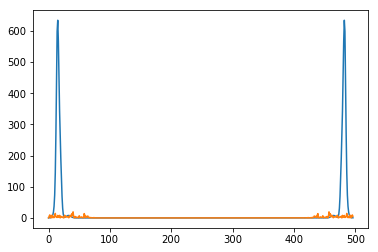

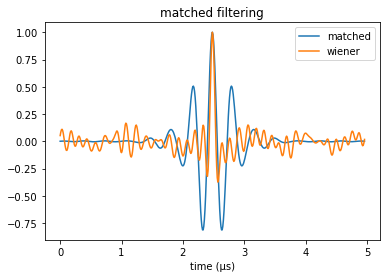

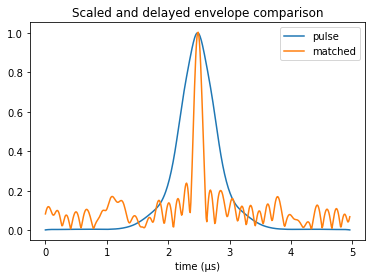

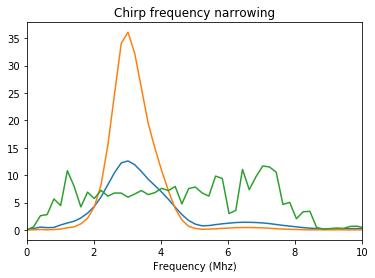

In [84]:
aim = np.zeros(xp.shape)
aim[int(len(aim)/2)] = 1

noise = 0.1*np.random.randn(len(xp))
# Let lowpass the noise this time for a fair comparison
b,a = sp.butter(6,0.25)
noise = sp.lfilter(b,a,noise)

H = np.fft.fft(xp)/np.fft.fft(aim)
S = abs(np.fft.fft(xp))**2
N = abs(np.fft.fft(noise))**2
G = np.conj(H)*S/(abs(H)**2*S + N)
result = np.real(np.fft.ifft((np.fft.fft(xp+noise)*G)))

plt.plot(S)
plt.plot(N)
plt.show()

#plt.plot(t/1e-6,xc,label='chirp')
plt.plot(tp/1e-6,firPulse,label='matched')
plt.plot(tp/1e-6,result/np.max(result),label='wiener')
plt.xlabel('time (µs)')
plt.legend()
plt.title('matched filtering')
plt.show()

# Plot envelope comparison
plt.plot(tp/1e-6,np.abs(sp.hilbert(firPulse)),label='pulse')
plt.plot(tp/1e-6,np.abs(sp.hilbert(result/np.max(result))),label='matched')
plt.xlabel('time (µs)')
plt.title('Scaled and delayed envelope comparison')
plt.legend()
plt.show()

freqs = np.fft.fftshift(np.fft.fftfreq(len(xp),dt))/1e6
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(xp/2))))
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(firPulse))))
plt.plot(freqs, np.fft.fftshift(np.abs(np.fft.fft(result)/np.max(result))))
plt.xlim([0, 10])
plt.xlabel('Frequency (Mhz)')
plt.title('Chirp frequency narrowing')
plt.show()

## Conclusion

We have shown the power of matcher filter in order to reduce noise. In our case it won't improve resolution but allows to obtain a symmetric point spread function and to efficiently reject noise. It could be usefull to find a proper way to mesure the impulse response of our system since it may differ with the one of the constructor.

Thanks for reading

Alister Trabattoni